# 시계열분석 (Time Series)
---
* 시간 ! : 특정 간격 갖는 시간 (Lag)   
      - Lag에서 Data의 Trend를 찾는다!    

* 일변량 정상시계열  
      - ARIMA  
  
  
- Trend : 추세  
- Seasonality : 계절성  
- Cycle : 주기  
- Noise : 잡음 -> White Noise  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family = 'Malgun Gothic')

In [3]:
df_origin = pd.read_csv('./시계열분석.csv')
df = df_origin.copy()

# [1] 데이터 탐색
    - 구매일 : object 타입이므로 변환 필요

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803675 entries, 0 to 803674
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   구매일     803675 non-null  object
 1   구매금액    803675 non-null  int64 
 2   물품대분류   803675 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.4+ MB


In [5]:
df.head()

,구매일,구매금액,물품대분류
0,2018-04-20,57120,기저귀
1,2018-04-20,15900,더블하트
2,2018-04-20,7000,더블하트
3,2018-04-20,20900,더블하트
4,2018-05-06,26500,더블하트


In [6]:
df.isnull().sum()

구매일      0
구매금액     0
물품대분류    0
dtype: int64

In [9]:
# 구매일 컬럼 : object -> datetime으로 변환
df['Datetime'] = pd.to_datetime(df['구매일'])
df['Datetime'].describe()

# 기간 사이에 날짜가 비어있음을 알 수있다.

C:\Users\minsoo\AppData\Local\Temp\ipykernel_9892\3067814066.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['Datetime'].describe()


count                  803675
unique                    589
top       2019-10-11 00:00:00
freq                    10500
first     2018-04-20 00:00:00
last      2020-08-07 00:00:00
Name: Datetime, dtype: object

In [18]:
# 연,월,주,요일 컬럼 생성
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Week'] = df['Datetime'].dt.isocalendar().week
df['Day'] = df['Datetime'].dt.day_name()
df.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day
0,2018-04-20,57120,기저귀,2018-04-20,2018,4,16,Friday
1,2018-04-20,15900,더블하트,2018-04-20,2018,4,16,Friday
2,2018-04-20,7000,더블하트,2018-04-20,2018,4,16,Friday
3,2018-04-20,20900,더블하트,2018-04-20,2018,4,16,Friday
4,2018-05-06,26500,더블하트,2018-05-06,2018,5,18,Sunday


#### [1-1] 시각화를 통해 시계열 데이터 분석하기

<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

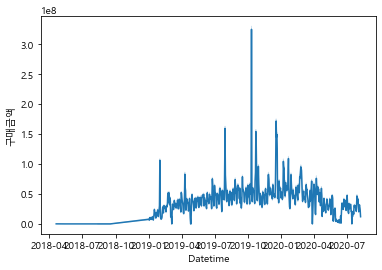

In [22]:
# 시간에 따른 구매금액 등을 알고 싶으면 estimator = sum 사용 
plt.figure(figsize= [10,5])
sns.lineplot(data = df, x ='Datetime', y = '구매금액', estimator= sum)

In [24]:
# 위의 방법은 데이터가 많아서 합을 계산하는 등 시간이 오래걸림
# -> 피보팅으로 일별 합을 계산해서 그리기(훨씬 시간이 빨라짐)
p1 = pd.pivot_table(data = df,
                    index = 'Datetime',
                    values = '구매금액',
                    aggfunc = 'sum').reset_index()
p1

,Datetime,구매금액
0,2018-04-20,100920
1,2018-05-06,26500
2,2018-05-14,20600
3,2018-08-12,75700
4,2018-09-01,48300
...,...,...
584,2020-08-03,27560340
585,2020-08-04,31832500
586,2020-08-05,27683180
587,2020-08-06,22574070


In [31]:
p2 = pd.pivot_table(data = df,
                    index = ['Datetime','물품대분류'],
                    values = '구매금액',
                    aggfunc = 'sum').reset_index()
p2

,Datetime,물품대분류,구매금액
0,2018-04-20,기저귀,57120
1,2018-04-20,더블하트,43800
2,2018-05-06,더블하트,26500
3,2018-05-14,FC,20600
4,2018-08-12,더블하트,75700
...,...,...,...
5241,2020-08-07,기타,182400
5242,2020-08-07,더블하트,408480
5243,2020-08-07,물티슈,100300
5244,2020-08-07,체험팩,112050


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

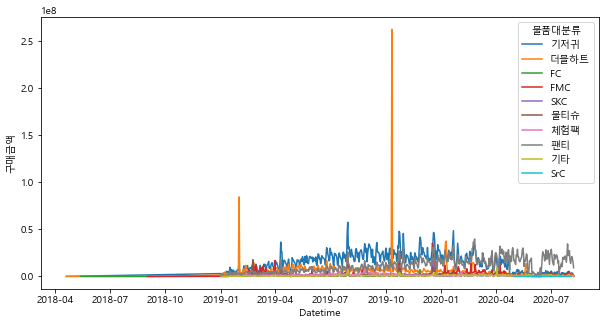

In [32]:
plt.figure(figsize= [10,5])
sns.lineplot(data = p2, x = 'Datetime', y = '구매금액', hue = '물품대분류')

# 더블하트 같이 너무 차이가 나는 특수한 경우, 트렌드 파악을 방해할 가능성이 많으므로 제거해주는 것이 좋음

In [35]:
# 기저귀 데이터 확인
cond1 = (df['물품대분류']=='기저귀')
df.loc[cond1]

# 2018년 ~ 2019년 5월까지 데이터가 아예 없으므로 트렌드분석에 도움이 되지 않아 제외시키기

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day
0,2018-04-20,57120,기저귀,2018-04-20,2018,4,16,Friday
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
...,...,...,...,...,...,...,...,...
803578,2020-06-25,43400,기저귀,2020-06-25,2020,6,26,Thursday
803602,2020-06-26,43400,기저귀,2020-06-26,2020,6,26,Friday
803610,2020-06-28,49900,기저귀,2020-06-28,2020,6,26,Sunday
803631,2020-07-09,49900,기저귀,2020-07-09,2020,7,28,Thursday


In [36]:
df2 = df.loc[cond1].iloc[1:]
df2.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
33,2019-07-29,101280,기저귀,2019-07-29,2019,7,31,Monday


# [2] 모델 생성 (ARIMA, Auto Regressive Integrated Moving Average Model)
---
#### AR (Auto Regressive Model) : 자기 회귀 모델
    - 정의: p 시점 전의 자료가 현재 시점의 데이터에 영향을 주는 자기회귀모델
    - 예시: 주가( 다음날 시가가 전날 종가에서 시작)
    - 약점: 물품대란 등 불특정하고 불필요하고 불규칙적인 변동에 약함. -> MA와 함께 사용하여 해결

    - 자기상관함수 (ACF : Auto Correlation Function) 
        - p 구간 내 데이터 사이의 상관관계 (교회 - 범죄 - [인구])
    - 부분자기상관함수 (PACF : Partial Auto Correlation Function) : 
        - 다른 시점의 데이터들의 영향을 제외한 두 관측치 사이의 상관관계 (교회 - 범죄 !- [인구])  
    - 일반적인 AR 모델에서는 ACF는 일정히 감소 / PACF가 절단면을 갖는다 
    - ACF와 PACF를 확인하여 분석 모델을 선택한다 
#### MA (Moving Average Model) : 이동평균모델
    - 일정한 구간 데이터의 평균을 계산해 미래를 예측하는 모델

#### Diffrence : 차분
    - 대부분 실제 데이터는 비정상열 데이터
    - 정상성(평균,차분 등)을 만족하지 못하는 데이터에 대해 정상열로 변환 

# 조건
    - 단기예측에 적합함
    - 계절적 변동요인(주기적인 변동)
    - Sample > 50개 이상일 때
    - 정성적 자료

In [38]:
#!pip install statsmodels 

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 9.1/9.1 MB 3.9 MB/s eta 0:00:00
     -------------------------------------- 233.7/233.7 kB 4.8 MB/s eta 0:00:00


In [39]:
import statsmodels.tsa.api as tsa

In [40]:
df2.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
33,2019-07-29,101280,기저귀,2019-07-29,2019,7,31,Monday


In [42]:
df_time = pd.pivot_table(
    data = df2, 
    index = 'Datetime',
    values = '구매금액',
    aggfunc='sum')

df_time.head()

,구매금액
Datetime,
2019-01-01,3051240
2019-01-02,2556280
2019-01-03,2729480
2019-01-04,2238440
2019-01-05,2478680


In [45]:
# datetime을 인덱스로 잡아두고 분석하는 것이 좋음
# 예시
df_time_2 = pd.pivot_table(
    data = df2, 
    index = 'Datetime',
    values = '구매금액',
    aggfunc='sum').reset_index()

df_time_2.head()

,Datetime,구매금액
0,2019-01-01,3051240
1,2019-01-02,2556280
2,2019-01-03,2729480
3,2019-01-04,2238440
4,2019-01-05,2478680


In [46]:
df_time_2.set_index('Datetime')

,구매금액
Datetime,
2019-01-01,3051240
2019-01-02,2556280
2019-01-03,2729480
2019-01-04,2238440
2019-01-05,2478680
...,...
2020-08-03,3075900
2020-08-04,4010200
2020-08-05,2937800


In [52]:
# 일주일 단위로 묶기
y = df_time['구매금액'].resample('1D').mean()

In [58]:
# 결측치 확인
print(y.isnull().sum())

# 시계열은 결측치를 채워줄 때, 바로 이전의 데이터나 이후의 데이터로 채워주는 것이 좋음 (평균X)
y1 = y.fillna(method = 'ffill') #or y.fillna(methods = 'bfill') 

7


[시계열 분해]  
    - Trend  
    - Seasonality  
    - residual: 잔차  

In [60]:
from pylab import rcParams 

In [61]:
rcParams['figure.figsize'] = 15,10

#차트 기본 크기 설정
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

C:\Users\minsoo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\ProgramData\Miniconda3\envs\EV_PY39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


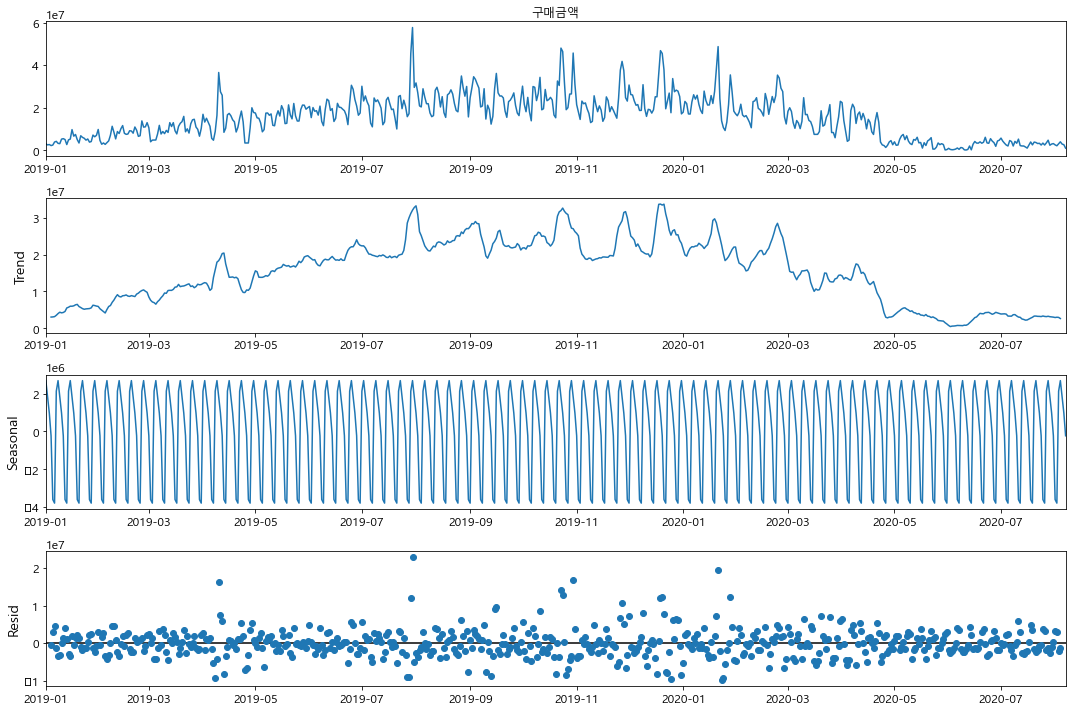

In [62]:
# 시계열 모델 생성
model_series = tsa.seasonal_decompose(y1, model = 'additive')

# 모델 시각화
fig = model_series.plot()
plt.show()